# Breaking a neural network


My attempt to convince a neural network that my cat is actually a mouse, or maybe some othero bject as well (_Hint:_ It actually works!)


Based on the amazing work of Julia Evans:
https://codewords.recurse.com/issues/five/why-do-neural-networks-think-a-panda-is-a-vulture
Many details have been removed. Please check her original blog post to better understand what's happening.

# Part 1 - Setup

### Prepare libraries and load labels

In [242]:
# Imports
import shutil
import requests
import tempfile
import sys
import os
import caffe

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Nicer display for graphs
pd.set_option('display.mpl_style', False)

# Show plots as static images
%matplotlib inline

caffe_root = '/opt/caffe/'
sys.path.insert(0, caffe_root + 'python')

plt.rcParams['figure.figsize'] = (4, 4)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

In [276]:
# Load the labels for the images in the set
imagenet_labels_filename = caffe_root + '/data/ilsvrc12/synset_words.txt'
try:
    labels = np.loadtxt(imagenet_labels_filename, str, delimiter='\t')
except:
    # Download auxiliary files if not present
    !/opt/caffe/data/ilsvrc12/get_ilsvrc_aux.sh
    labels = np.loadtxt(imagenet_labels_filename, str, delimiter='\t')

### Load the model

In [277]:
# Set Caffe to CPU mode
caffe.set_mode_cpu()

# Load our model! trained by the GOOGLES! <3
def load_model():
    BATCH_SIZE = 1
    net = caffe.Net('/opt/caffe/models/bvlc_googlenet/deploy.prototxt',
                    '/models/bvlc_googlenet.caffemodel',
                    caffe.TEST)
    # change batch size to 1 for faster processing
    # this just means that we're only processing one image at a time instead of like 50
    shape = list(net.blobs['data'].data.shape)
    shape[0] = BATCH_SIZE
    net.blobs['data'].reshape(*shape)
    net.blobs['prob'].reshape(BATCH_SIZE, )
    net.reshape() 
    return net

net = load_model()

# Caffe comes with a handy transformer pipeline so that
# we can make our images into the format it needs! Yay!
transformer = caffe.io.Transformer({'data': net.blobs['data'].data.shape})
transformer.set_transpose('data', (2,0,1))
transformer.set_raw_scale('data', 255)  # the reference model operates on images in [0,255] range instead of [0,1]
transformer.set_channel_swap('data', (2,1,0))  # the reference model has channels in BGR order instead of RGB

### Auxiliary functions

In [278]:
# Download images from URL and convert to PNG
def get_png_image(url):
    fd, path = tempfile.mkstemp()
    tmpfile = os.fdopen(fd, "wb")
    response = requests.get(url, stream=True)
    shutil.copyfileobj(response.raw, tmpfile)
    if 'png' in url:
        !mv {path} {path}.png
    else:
        !convert {path} {path}.png
    path = path + ".png"
    
    return transformer.preprocess('data', caffe.io.load_image(path))

# Display the image
def display(data):
    plt.imshow(transformer.deprocess('data', data))

# Get label associated with entry number 'num' 
# 'num' - a line number in synset_words.tx file
# E.g. line 701 - n03887697 paper towel
# So "paper towel" has number 700
def get_label_name(num):
    options = labels[num].split(',')

    # Remove the tag
    options[0] = ' '.join(options[0].split(' ')[1:])
    
    return ','.join(options[:2])

# Get first 'n_preds' for an image
def predict(data, n_preds = 6, display_output = True):
    net.blobs['data'].data[...] = data
    if display_output:
        display(data)
    prob = net.forward()['prob']
    probs = prob[0]
    prediction = probs.argmax()
    top_k = probs.argsort()[::-1]
    for pred in top_k[:n_preds]:
        percent = round(probs[pred] * 100, 2)
        # display it compactly if we're displaying more than the top prediction
        pred_formatted = "%03d" % pred
        if n_preds == 1:
            format_string = "label: {cls} ({label})\ncertainty: {certainty}%"
        else:
            format_string = "label: {cls} ({label}), certainty: {certainty}%"
        if display_output:
            print format_string.format(
                cls=pred_formatted, label=get_label_name(pred), certainty=percent)
    return prob

### Testing the network

We're going to test the network first. A **Persian cat ** is detected in the image, with probability 13.94%. Sounds about right.

All good, let's move on and try to trick the network towards diferent predictions.

label: 283 (Persian cat)
certainty: 13.94%


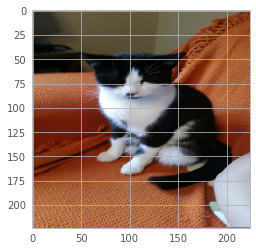

In [284]:
img_url = 'https://github.com/livz/livz.github.io/raw/master/assets/images/liz.jpg'
img_data = get_png_image(img_url)
probs = predict(img_data, n_preds=1)

# Part 2 - Breaking the predictions

### Step 1: Calculate the gradient

Calculate the gradient of the neural network. The gradient is the derivative of the network. 

The intuition behind this is that the gradient represents the direction to take to make the image look like something.

In [285]:
def compute_gradient(image_data, intended_outcome):
    predict(image_data, display_output=False)
    
    # Get an empty set of probabilities
    probs = np.zeros_like(net.blobs['prob'].data)
    
    # Set the probability for our intended outcome to 1
    probs[0][intended_outcome] = 1
    
    # Do backpropagation to calculate the gradient for that outcome
    gradient = net.backward(prob=probs)
    
    return gradient['data'].copy()

In [288]:
mouse = 673        # Line 674 in synset_words.txt
grad = compute_gradient(img_data, mouse)

Because the gradient is the same shape as the the original image, we can _display it as an image!_. We need to scale it up otherwise it won't be visible, since the order of magniture of gradient is e-08

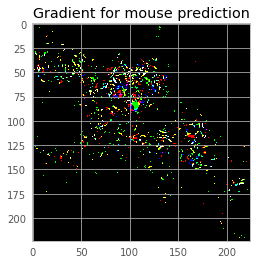

In [289]:
# Display scaled gradient
display(grad / np.percentile(grad, 98))

plt.title('Gradient for mouse prediction')

### Step 2: Find the direction towards a different prediction

We've already calculated `grad` via `compute_gradient()` function, and drawn it as a picture. In this step we want to create a `delta` which emphasizes the pixels in the picture that the neural network thinks are important.

Below we can play with different values, and add or substract small multiples of delta from our image and see how the predictions change.

The modified image is then displayed. Notice how the pixels are _slightly affected_ by the previous operation.

label: 253 (basenji), certainty: 8.88%
label: 478 (carton), certainty: 4.6%
label: 250 (Siberian husky), certainty: 4.32%
label: 263 (Pembroke, Pembroke Welsh corgi), certainty: 4.14%
label: 195 (Boston bull, Boston terrier), certainty: 3.96%


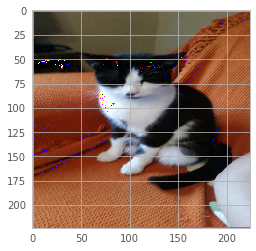

In [290]:
delta = np.sign(grad)
multiplicator = 0.9
new_predictions = predict(np.round(img_data + multiplicator*delta), n_preds=5)

We've added a very light version of the gradient to the original image. This should increase the probability of the label we used to compute the gradient - _mouse_, which now has 52.87% probability.

We'll test in a loop to find the best value to multiply the gradient with in order to get the desired prediction.

### Step 3:  Loop to find the best values

**Slowly** go towards a different prediction. At each step compute the gradient for our desired label, and make a slight update of the image. The following steps computes the gradiend _of the updated image_ then updates it slightly.

The **_most interesting function_** of this whole session is below. Spend a few minutes on it!

In [291]:
def trick(image, desired_label, n_steps=10):
    # Maintain a list of outputs at each step
    # Will be usefl later to plot the evolution of labels at each step.
    prediction_steps = []
    
    for _ in range(n_steps - 1):
        preds = predict(image, display_output=False)
        prediction_steps.append(np.copy(preds))
        grad = compute_gradient(image, desired_label)
        delta = np.sign(grad)
        # If there are n steps, we make them size 1/n -- small!
        image = image + delta * 0.9 / n_steps
    return image, prediction_steps

#### Transform the cat into a mouse

label: 283 (Persian cat), certainty: 13.94%
label: 700 (paper towel), certainty: 13.38%
label: 673 (mouse, computer mouse), certainty: 6.05%
label: 478 (carton), certainty: 5.66%
label: 508 (computer keyboard, keypad), certainty: 4.7%


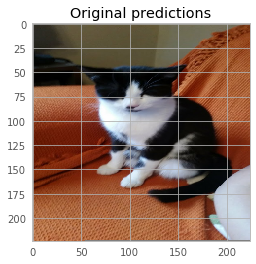

In [292]:
# Check Original predictions
pred  = predict(img_data, n_preds=5)
plt.title("Original predictions")

In [297]:
mouse_label = 673
penguin_label = 145
new_image, steps = trick(img_data, penguin_label, n_steps=30)

label: 145 (king penguin, Aptenodytes patagonica), certainty: 51.84%
label: 678 (neck brace), certainty: 4.76%
label: 018 (magpie), certainty: 4.27%
label: 667 (mortarboard), certainty: 3.02%
label: 013 (junco, snowbird), certainty: 2.52%
label: 148 (killer whale, killer), certainty: 2.04%


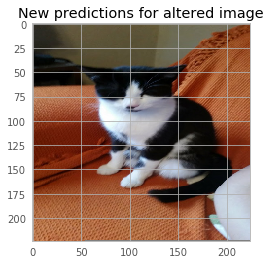

In [298]:
preds = predict(new_image)
plt.title("New predictions for altered image")

After only 10 iterations, the cat can become a mouse with 96.72% probability, or a king penguin with a probability of 51.84% after 30. And there is no visible change in the image pixels_!_

In [261]:
# Plot evolution of different labels at each step
def plot_steps(steps, label_list, **args):
    d = {}
    for label in label_list:
        d[get_label_name(label)] = [s[0][label] for s in steps]
    df = pd.DataFrame(d)
    df.plot(**args)
    plt.xlabel('Step number')
    plt.ylabel('Probability of label')

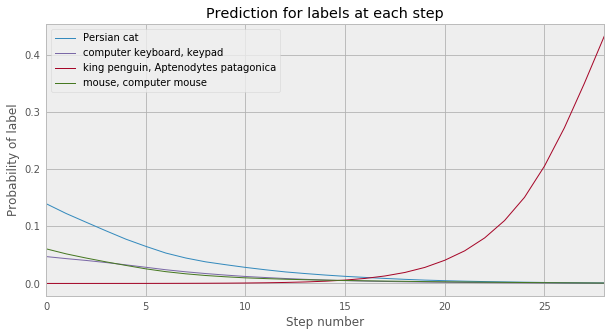

In [299]:
mouse_label = 673
keyboard_label = 508
persian_cat_label = 283
penguin_label = 145

label_list = [mouse_label, keyboard_label, persian_cat_label, penguin_label]
plot_steps(steps, label_list, figsize=(10, 5))
plt.title("Prediction for labels at each step")

#### Transform the cat

Initially the first prediction was Persian cat (label 283) with 13.94% certainty. Let's try to obtain a better score

label: 283 (Persian cat), certainty: 99.9%
label: 332 (Angora, Angora rabbit), certainty: 0.03%
label: 281 (tabby, tabby cat), certainty: 0.01%
label: 259 (Pomeranian), certainty: 0.01%
label: 700 (paper towel), certainty: 0.01%
label: 478 (carton), certainty: 0.0%


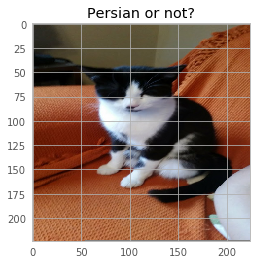

In [283]:
persian_cat_label = 283
cat_persian, steps = trick(img_data, persian_cat_label, n_steps=10)
preds = predict(cat_persian)
plt.title("Persian or not?")

Persian cat with 99.9% confidence!